<a href="https://colab.research.google.com/github/sadigsago/PyTorch-GAN/blob/master/notebooks/inference_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyDrive activation Used for bypassing Google Drive download rate limit

In [44]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

## Step 1 - Install Packages required by PTI

In [45]:
## Other packages are already builtin in the Colab interpreter
!pip install wandb
!pip install lpips

## Used for faster inference of StyleGAN by enabling C++ code compilation

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
--2025-05-28 11:46:37--  https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objec

## Step 2 - Download Pretrained models

In [46]:
import os
os.chdir('/content')
CODE_DIR = 'PTI'

In [47]:
!git clone https://github.com/danielroich/PTI.git $CODE_DIR

fatal: destination path 'PTI' already exists and is not an empty directory.


In [48]:
os.chdir(f'./{CODE_DIR}')

In [49]:
import os
import sys
import pickle
import numpy as np
from PIL import Image
import torch
from configs import paths_config, hyperparameters, global_config
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from IPython.display import display
import matplotlib.pyplot as plt
from scripts.latent_editor_wrapper import LatentEditorWrapper

In [50]:
current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
os.makedirs(save_path, exist_ok=True)

In [51]:
## Download pretrained StyleGAN on FFHQ 1024x1024
downloader.download_file("125OG7SMkXI-Kf2aqiwLLHyCvSW-gZk3M", os.path.join(save_path, 'ffhq.pkl'))

In [53]:
## Download Dlib tool for alingment, used for preprocessing images before PTI
downloader.download_file("1xPmn19T6Bdd-_RfCVlgNBbfYoh1muYxR", os.path.join(save_path, 'align.dat'))

## Step 3 - Configuration Setup

In [54]:
image_dir_name = 'image'

## If set to true download desired image from given url. If set to False, assumes you have uploaded personal image to
## 'image_original' dir
use_image_online = True
image_name = 'personal_image'
use_multi_id_training = False
global_config.device = 'cuda'
paths_config.e4e = '/content/PTI/pretrained_models/e4e_ffhq_encode.pt'
paths_config.input_data_id = image_dir_name
paths_config.input_data_path = f'/content/PTI/{image_dir_name}_processed'
paths_config.stylegan2_ada_ffhq = '/content/PTI/pretrained_models/ffhq.pkl'
paths_config.checkpoints_dir = '/content/PTI/'
paths_config.style_clip_pretrained_mappers = '/content/PTI/pretrained_models'
hyperparameters.use_locality_regularization = False

## Step 4 - Preproccess Data

In [57]:
os.makedirs(f'./{image_dir_name}_original', exist_ok=True)
os.makedirs(f'./{image_dir_name}_processed', exist_ok=True)
os.chdir(f'./{image_dir_name}_original')

In [58]:
## Download real face image
## If you want to use your own image skip this part and upload an image/images of your choosing to image_original dir
if use_image_online:
  !wget -O personal_image.jpg https://static01.nyt.com/images/2019/09/09/opinion/09Hunter1/09Hunter1-superJumbo.jpg ## Photo of Sarena Wiliams

--2025-05-28 11:54:56--  https://static01.nyt.com/images/2019/09/09/opinion/09Hunter1/09Hunter1-superJumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 818859 (800K) [image/jpeg]
Saving to: ‘personal_image.jpg’

personal_image.jpg  100%[===================>] 799.67K  --.-KB/s    in 0.04s   

2025-05-28 11:54:56 (21.6 MB/s) - ‘personal_image.jpg’ saved [818859/818859]



In [62]:
original_image = Image.open('{image_name}.png')
original_image

FileNotFoundError: [Errno 2] No such file or directory: '{image_name}.png'

In [63]:
os.chdir('/content/PTI')

In [64]:
pre_process_images(f'/content/PTI/{image_dir_name}_original')

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


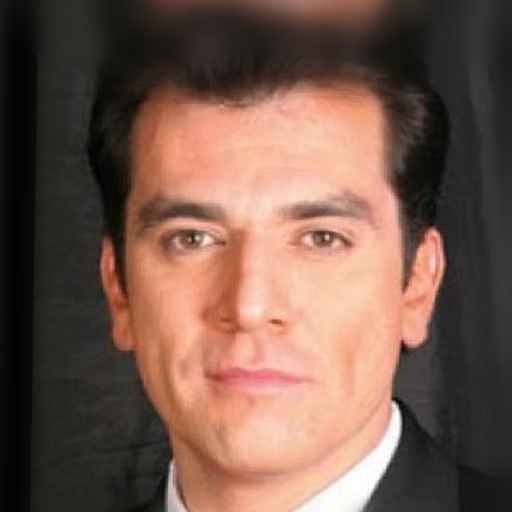

In [65]:
aligned_image = Image.open(f'/content/PTI/{image_dir_name}_processed/{image_name}.jpeg')
aligned_image.resize((512,512))

## Step 5 - Invert images using PTI

In order to run PTI and use StyleGAN2-ada, the cwd should the parent of 'torch_utils' and 'dnnlib'.

In case use_multi_id_training is set to True and many images are inverted simultaneously
activating the regularization to keep the *W* Space intact is recommended.

If indeed the regularization is activated then please increase the number of pti steps from 350 to 450 at least
using hyperparameters.max_pti_steps

In [66]:
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 203MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.



  0%|          | 0/450 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.



100%|██████████| 450/450 [01:23<00:00,  5.40it/s]

100%|██████████| 1/1 [02:17<00:00, 137.71s/it]


## Visualize results

In [67]:
def display_alongside_source_image(images):
    res = np.concatenate([np.array(image) for image in images], axis=1)
    return Image.fromarray(res)

In [73]:
def load_generators(model_id, image_name):
  with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
    old_G = pickle.load(f)['G_ema'].cuda()

  with open(f'{paths_config.checkpoints_dir}/model_{model_id}_{image_name}.pt', 'rb') as f_new:
    new_G = torch.load(f_new, weights_only=False).cuda()

  return old_G, new_G

In [74]:
generator_type = paths_config.multi_id_model_type if use_multi_id_training else image_name
old_G, new_G = load_generators(model_id, generator_type)

In [70]:
def plot_syn_images(syn_images):
  for img in syn_images:
      img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()[0]
      plt.axis('off')
      resized_image = Image.fromarray(img,mode='RGB').resize((256,256))
      display(resized_image)
      del img
      del resized_image
      torch.cuda.empty_cache()

If multi_id_training was used for several images.
You can alter the w_pivot index which is currently configured to 0, and then running
the visualization code again. Using the same generator on different latent codes.

In [75]:
w_path_dir = f'{paths_config.embedding_base_dir}/{paths_config.input_data_id}'
embedding_dir = f'{w_path_dir}/{paths_config.pti_results_keyword}/{image_name}'
w_pivot = torch.load(f'{embedding_dir}/0.pt')

In [76]:
old_image = old_G.synthesis(w_pivot, noise_mode='const', force_fp32 = True)
new_image = new_G.synthesis(w_pivot, noise_mode='const', force_fp32 = True)

Upper image is the inversion before Pivotal Tuning and the lower image is the product of pivotal tuning


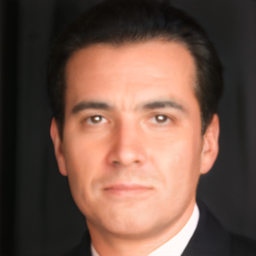

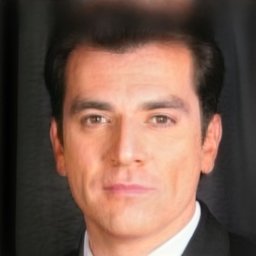

In [77]:
print('Upper image is the inversion before Pivotal Tuning and the lower image is the product of pivotal tuning')
plot_syn_images([old_image, new_image])

## InterfaceGAN edits

In [98]:
latent_editor = LatentEditorWrapper()
latents_after_edit = latent_editor.get_single_interface_gan_edits(w_pivot, [0, -3, 4])

In order to get different edits. Such as younger face or make the face smile more. Please change the factors passed to "get_single_interface_gan_edits".
Currently the factors are [-2,2]. You can pass for example: range(-3,3)

Showing rotation change


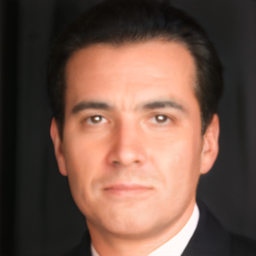

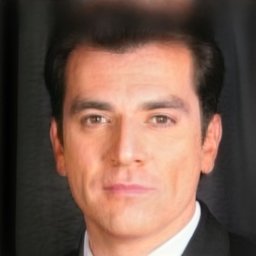

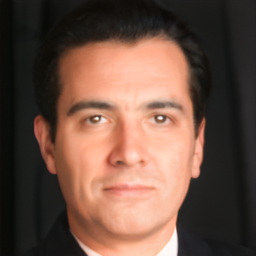

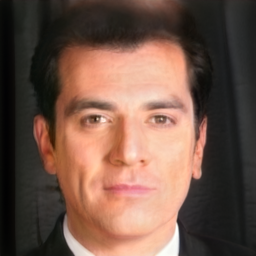

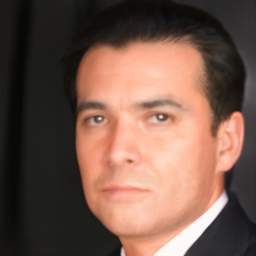

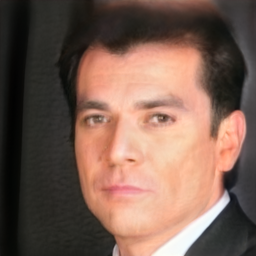

Showing smile change


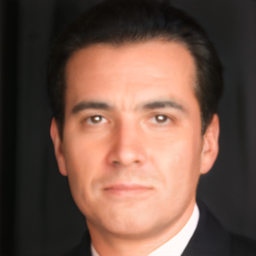

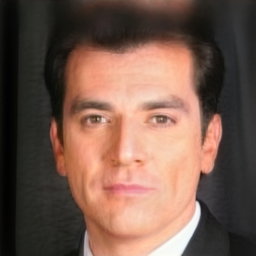

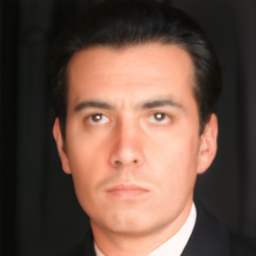

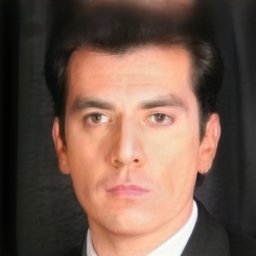

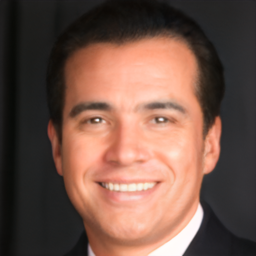

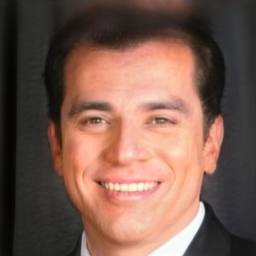

Showing age change


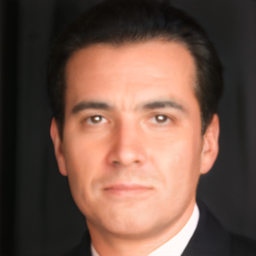

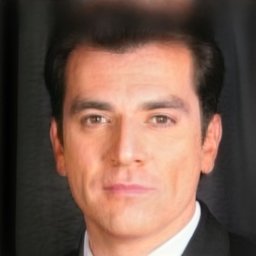

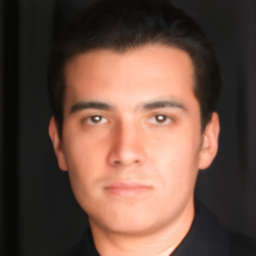

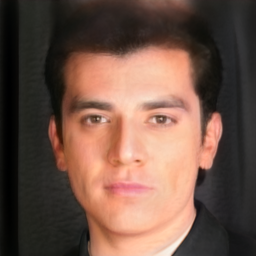

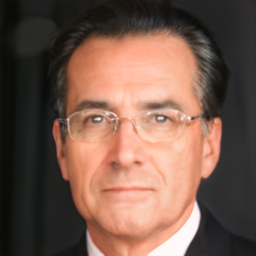

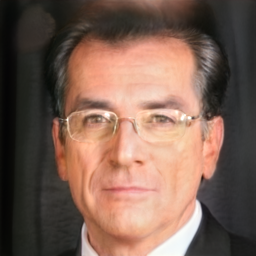

In [99]:
for direction, factor_and_edit in latents_after_edit.items():
  print(f'Showing {direction} change')
  for latent in factor_and_edit.values():
    old_image = old_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    new_image = new_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    plot_syn_images([old_image, new_image])

In [100]:
with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
  old_G = pickle.load(f)['G_ema'].cuda()

In [101]:
# Assuming old_G has been loaded as shown in the previous code block

# Get the total number of parameters
total_params = sum(p.numel() for p in old_G.parameters())

# Print the number of parameters
print(f"Total number of parameters in the ffhq.pkl model: {total_params}")

Total number of parameters in the ffhq.pkl model: 30370060


In [102]:
# Assuming new_G has been loaded after running PTI
# (This happens in the "Visualize results" section)

# Get the total number of parameters for the fine-tuned generator
total_params_new_G = sum(p.numel() for p in new_G.parameters())

# Print the number of parameters for the fine-tuned generator
print(f"Total number of parameters in the fine-tuned generator (new_G): {total_params_new_G}")

Total number of parameters in the fine-tuned generator (new_G): 30370060


## StyleCLIP editing

### Download pretrained models

In [ ]:
mappers_base_dir = '/content/PTI/pretrained_models'

In [ ]:
# More pretrained mappers can be found at: "https://github.com/orpatashnik/StyleCLIP/blob/main/utils.py"
# Download Afro mapper
downloader.download_file("1i5vAqo4z0I-Yon3FNft_YZOq7ClWayQJ", os.path.join(mappers_base_dir, 'afro.pt'))

In [ ]:
# Download Mohawk mapper
downloader.download_file("1oMMPc8iQZ7dhyWavZ7VNWLwzf9aX4C09", os.path.join(mappers_base_dir, 'mohawk.pt'))

In [ ]:
# Download e4e encoder, used for the first inversion step instead on the W inversion.
downloader.download_file("1cUv_reLE6k3604or78EranS7XzuVMWeO", os.path.join(mappers_base_dir, 'e4e_ffhq_encode.pt'))

### Use PTI with e4e backbone for StyleCLIP

In [ ]:
# Changing first_inv_type to W+ makes the PTI use e4e encoder instead of W inversion in the first step
hyperparameters.first_inv_type = 'w+'
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

### Apply edit

In [ ]:
from scripts.pti_styleclip import styleclip_edit

In [ ]:
paths_config.checkpoints_dir = '/content/PTI'
os.chdir('/content/PTI')
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types = ['afro'], use_wandb=False)
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types = ['mohawk'], use_wandb=False)

In [ ]:
original_styleCLIP_path = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/e4e/{image_name}_afro.jpg'
new_styleCLIP_path  = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/PTI/{image_name}_afro.jpg'
original_styleCLIP = Image.open(original_styleCLIP_path).resize((256,256))
new_styleCLIP =  Image.open(new_styleCLIP_path).resize((256,256))

In [ ]:
display_alongside_source_image([original_styleCLIP, new_styleCLIP])

In [ ]:
original_styleCLIP_path = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/e4e/{image_name}_mohawk.jpg'
new_styleCLIP_path  = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/PTI/{image_name}_mohawk.jpg'
original_styleCLIP = Image.open(original_styleCLIP_path).resize((256,256))
new_styleCLIP =  Image.open(new_styleCLIP_path).resize((256,256))

In [ ]:
display_alongside_source_image([original_styleCLIP, new_styleCLIP])

## Other methods comparison

### Invert image using other methods

In [ ]:
from scripts.latent_creators import e4e_latent_creator
from scripts.latent_creators import sg2_latent_creator
from scripts.latent_creators import sg2_plus_latent_creator

In [ ]:
e4e_latent_creator = e4e_latent_creator.E4ELatentCreator()
e4e_latent_creator.create_latents()
sg2_latent_creator = sg2_latent_creator.SG2LatentCreator(projection_steps = 600)
sg2_latent_creator.create_latents()
sg2_plus_latent_creator = sg2_plus_latent_creator.SG2PlusLatentCreator(projection_steps = 1200)
sg2_plus_latent_creator.create_latents()

In [ ]:
inversions = {}
sg2_embedding_dir = f'{w_path_dir}/{paths_config.sg2_results_keyword}/{image_name}'
inversions[paths_config.sg2_results_keyword] = torch.load(f'{sg2_embedding_dir}/0.pt')
e4e_embedding_dir = f'{w_path_dir}/{paths_config.e4e_results_keyword}/{image_name}'
inversions[paths_config.e4e_results_keyword] = torch.load(f'{e4e_embedding_dir}/0.pt')
sg2_plus_embedding_dir = f'{w_path_dir}/{paths_config.sg2_plus_results_keyword}/{image_name}'
inversions[paths_config.sg2_plus_results_keyword] = torch.load(f'{sg2_plus_embedding_dir}/0.pt')

In [ ]:
def get_image_from_w(w, G):
  if len(w.size()) <= 2:
      w = w.unsqueeze(0)
  img = G.synthesis(w, noise_mode='const', force_fp32=True)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()
  return img[0]

In [ ]:
def plot_image_from_w(w, G):
  img = get_image_from_w(w, G)
  plt.axis('off')
  resized_image = Image.fromarray(img,mode='RGB').resize((256,256))
  display(resized_image)

In [ ]:
for inv_type, latent in inversions.items():
  print(f'Displaying {inv_type} inversion')
  plot_image_from_w(latent, old_G)
print(f'Displaying PTI inversion')
plot_image_from_w(w_pivot, new_G)